<a href="https://colab.research.google.com/github/Jayasri02Sridharan/Reinsurance-Pricing-Claim-Simulation/blob/main/4_Simulation_Reinsurance_pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
df = pd.read_csv("/content/allstate_cleaned_claims.csv")
loss_data = df["loss"].values

print("Dataset size:", len(loss_data))
print("Min:", loss_data.min())
print("Max:", loss_data.max())
print("Mean:", loss_data.mean())

Dataset size: 188318
Min: 0.67
Max: 121012.25
Mean: 3037.3376856699833


### 1. Severity distribution

We assume Lognormal fits best from earlier analysis

In [ ]:
loss_data = loss_data[np.isfinite(loss_data)]
loss_data = loss_data[loss_data > 0]

sigma_hat, loc_hat, scale_hat = stats.lognorm.fit(loss_data, floc=0)

print("Lognormal sigma =", sigma_hat)
print("Lognormal scale =", scale_hat)

Lognormal sigma = 0.8118659387150827
Lognormal scale = 2176.052735723772


### 2. Frequency model

We assume Negative binomial is better (var > mean)

In [ ]:
# ASSUMPTION: average annual claims = 15000 (synthetic exposure assumption)
mu_N = 15000

# dispersion parameter (chosen from overdispersion)
r_hat = 5000

# convert to p for scipy nbinom
p_hat = r_hat / (r_hat + mu_N)

print("NegBin mean:", mu_N)
print("NegBin r:", r_hat)
print("NegBin p:", p_hat)

NegBin mean: 15000
NegBin r: 5000
NegBin p: 0.25


Remark: This is a portfolio assumption since Allstate lacks time exposure.

### 3. Monte Carlo simulate annual aggregate losses

In [ ]:
n_years = 20000  # simulate 20,000 policy years

np.random.seed(42)
# Simulate frequency N
N_sim = stats.nbinom.rvs(n=r_hat, p=p_hat, size=n_years)
print("Simulated mean N:", np.mean(N_sim))
print("Simulated var N:", np.var(N_sim))

# Simulate Aggregate Loss S
S_sim = np.zeros(n_years)

for i in range(n_years):
    n_claims = N_sim[i]
    if n_claims > 0:
        severities = stats.lognorm.rvs(s=sigma_hat, scale=scale_hat, size=n_claims)
        S_sim[i] = severities.sum()

Simulated mean N: 15001.31555
Simulated var N: 60433.829478197506


### 4. Analyze Aggregate Loss distribution

In [ ]:
print("Mean Aggregate Loss:", np.mean(S_sim))
print("Median Aggregate Loss:", np.median(S_sim))
print("95% VaR:", np.quantile(S_sim, 0.95))
print("99% VaR:", np.quantile(S_sim, 0.99))

Mean Aggregate Loss: 45385262.29985904
Median Aggregate Loss: 45380781.262713194
95% VaR: 46736612.03295434
99% VaR: 47345052.658458516


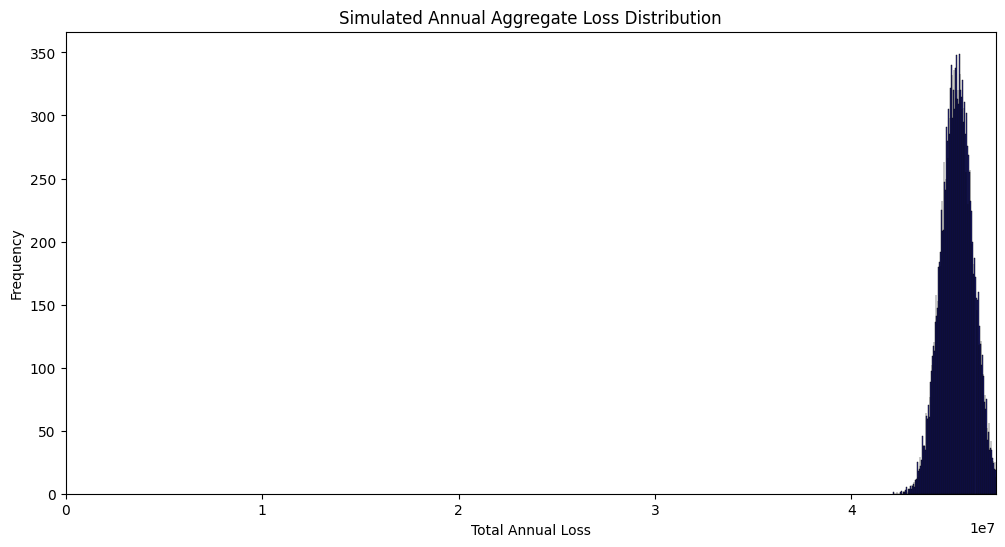

In [ ]:
# Plot Aggregate Loss distribution
plt.figure(figsize=(12,6))
sns.histplot(S_sim, bins=200, color="darkblue", alpha=0.8)
plt.title("Simulated Annual Aggregate Loss Distribution")
plt.xlabel("Total Annual Loss")
plt.ylabel("Frequency")
plt.xlim(0, np.quantile(S_sim, 0.99))
plt.show()

### 5. Tail Risk Measures (VaR and TVaR)

In [ ]:
def TVaR(sim_losses, p=0.99):
    var_p = np.quantile(sim_losses, p)
    return sim_losses[sim_losses > var_p].mean()

print("TVaR 95%:", TVaR(S_sim, 0.95))
print("TVaR 99%:", TVaR(S_sim, 0.99))

TVaR 95%: 47103047.50720229
TVaR 99%: 47631089.2376198


# Excess of Loss (Per Occurrence) Pricing

### 6. Simulate ceded loss under XL(per year)

In [ ]:
# Define XL reinsurance contract
# R = 5000
# L = 10000
R = np.quantile(loss_data, 0.95)
L = np.quantile(loss_data, 0.995) - R

print("Retention chosen:", R)
print("Limit chosen:", L)

ceded_XL = np.zeros(n_years)

for i in range(n_years):
    n_claims = N_sim[i]
    if n_claims > 0:
        severities = stats.lognorm.rvs(s=sigma_hat, scale=scale_hat, size=n_claims)
        ceded = np.minimum(np.maximum(severities - R, 0), L)
        ceded_XL[i] = ceded.sum()

Retention chosen: 8508.536499999998
Limit chosen: 8108.386550000047


### 7. XL Expected Loss + Premium

In [ ]:
EL_XL = np.mean(ceded_XL)

loading = 0.25  # 25% loading for risk + expenses
premium_XL = EL_XL * (1 + loading)

print("Expected Ceded Loss (XL):", EL_XL)
print("Loaded Premium (XL):", premium_XL)

Expected Ceded Loss (XL): 2287044.414728288
Loaded Premium (XL): 2858805.51841036


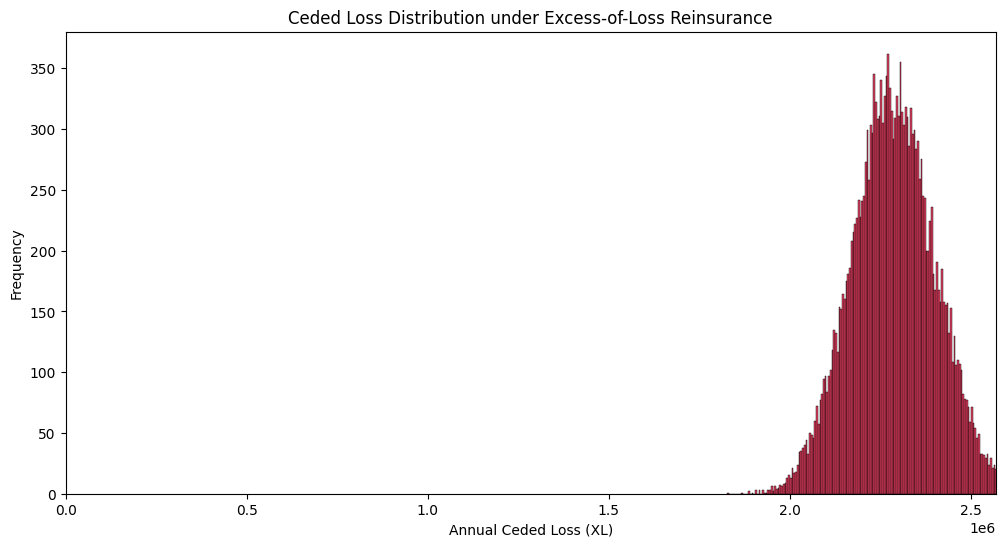

In [ ]:
# XL Loss distribution plot
plt.figure(figsize=(12,6))
sns.histplot(ceded_XL, bins=200, color="crimson", alpha=0.8)
plt.title("Ceded Loss Distribution under Excess-of-Loss Reinsurance")
plt.xlabel("Annual Ceded Loss (XL)")
plt.ylabel("Frequency")
plt.xlim(0, np.quantile(ceded_XL, 0.99))
plt.show()

# Stop Loss (Aggregate) Pricing

### 8. Stop loss expected loss + premium

In [ ]:
# Define Stop Loss Contract
A = np.quantile(S_sim, 0.90)  # deductible at 90th percentile
print("Stop Loss Attachment A:", A)

# Compute Stop Loss ceded losses
ceded_SL = np.maximum(S_sim - A, 0)

EL_SL = np.mean(ceded_SL)
premium_SL = EL_SL * (1 + loading)

print("Expected Ceded Loss (Stop Loss):", EL_SL)
print("Loaded Premium (Stop Loss):", premium_SL)



Stop Loss Attachment A: 46443839.13171256
Expected Ceded Loss (Stop Loss): 39736.79807996484
Loaded Premium (Stop Loss): 49670.997599956056


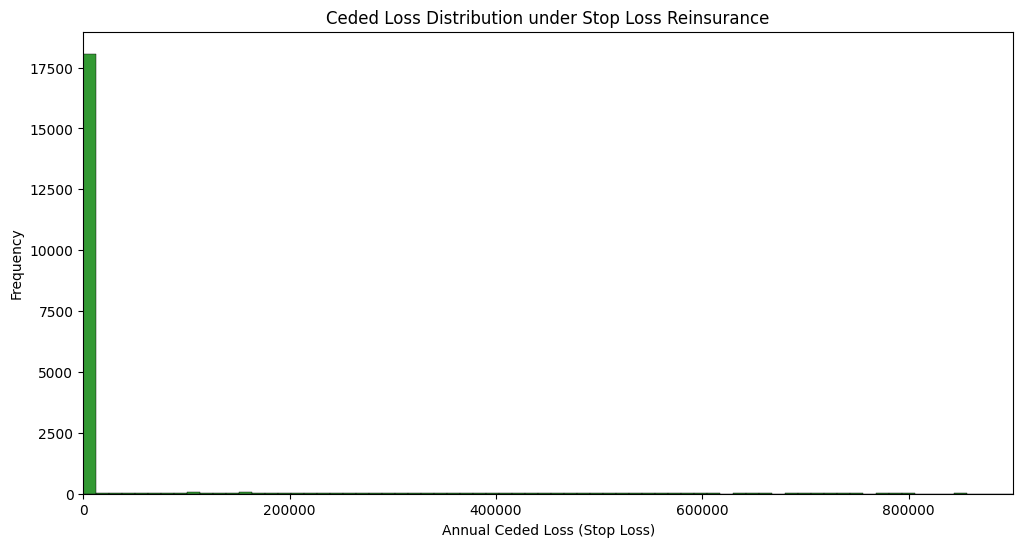

In [ ]:
# stop loss plot
plt.figure(figsize=(12,6))
sns.histplot(ceded_SL, bins=200, color="green", alpha=0.8)
plt.title("Ceded Loss Distribution under Stop Loss Reinsurance")
plt.xlabel("Annual Ceded Loss (Stop Loss)")
plt.ylabel("Frequency")
plt.xlim(0, np.quantile(ceded_SL, 0.99))
plt.show()

# Reinsurance Metrics table

### 9. Create summary table

In [ ]:
results = pd.DataFrame({
    "Contract": ["Excess of Loss", "Stop Loss"],
    "Expected Ceded Loss": [EL_XL, EL_SL],
    "Loaded Premium (25%)": [premium_XL, premium_SL],
    "VaR 95%": [np.quantile(ceded_XL, 0.95), np.quantile(ceded_SL, 0.95)],
    "VaR 99%": [np.quantile(ceded_XL, 0.99), np.quantile(ceded_SL, 0.99)],
    "TVaR 99%": [TVaR(ceded_XL, 0.99), TVaR(ceded_SL, 0.99)]
})

results

,Contract,Expected Ceded Loss,Loaded Premium (25%),VaR 95%,VaR 99%,TVaR 99%
0,Excess of Loss,3.639767e+06,4.549708e+06,6.998519e+06,7.164006e+06,7.242792e+06
1,Stop Loss,3.973680e+04,4.967100e+04,2.927729e+05,9.012135e+05,1.187250e+06


### 10. Conclusions

In [ ]:
print("=== ACTUARIAL CONCLUSIONS ===")
print(f"Aggregate Loss Mean: {np.mean(S_sim):,.2f}")
print(f"Aggregate Loss VaR 99%: {np.quantile(S_sim, 0.99):,.2f}")
print(f"Aggregate Loss TVaR 99%: {TVaR(S_sim, 0.99):,.2f}")

print("\nExcess-of-Loss Contract:")
print(f"Retention = {R}, Limit = {L}")
print(f"Expected Ceded Loss = {EL_XL:,.2f}")
print(f"Premium (with loading) = {premium_XL:,.2f}")

print("\nStop Loss Contract:")
print(f"Attachment = {A:,.2f}")
print(f"Expected Ceded Loss = {EL_SL:,.2f}")
print(f"Premium (with loading) = {premium_SL:,.2f}")

=== ACTUARIAL CONCLUSIONS ===
Aggregate Loss Mean: 45,385,262.30
Aggregate Loss VaR 99%: 47,345,052.66
Aggregate Loss TVaR 99%: 47,631,089.24

Excess-of-Loss Contract:
Retention = 5000, Limit = 10000
Expected Ceded Loss = 3,639,766.70
Premium (with loading) = 4,549,708.38

Stop Loss Contract:
Attachment = 46,443,839.13
Expected Ceded Loss = 39,736.80
Premium (with loading) = 49,671.00
